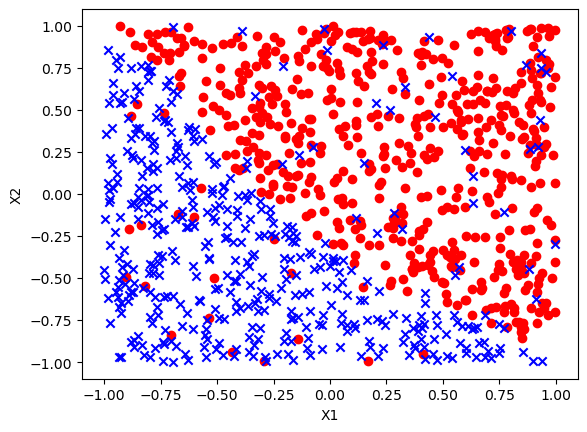

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # 用于设置最大刻度数量

# 读取数据
lines =np.loadtxt("lr_dataset.csv",delimiter=',',dtype=float)
x_total=lines[:,0:2]
y_total=lines[:,2]

# 将数据绘制到二维平面上
pos_index= np.where(y_total==1)
neg_index= np.where(y_total==0)
plt.scatter(x_total[pos_index,0],x_total[pos_index,1],marker='o',c='r')
plt.scatter(x_total[neg_index,0],x_total[neg_index,1],marker='x',c='b')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# 划分训练集测试集
np.random.seed(0)
ratio=0.7
split=int(len(x_total)*ratio)
#洗牌
idx=np.random.permutation(len(x_total))
x_total=x_total[idx]
y_total=y_total[idx]
x_train,x_test=x_total[:split],x_total[split:]
y_train,y_test=y_total[:split],y_total[split:]


In [31]:
def acc(y_true,y_pred):
    return np.mean(y_true==y_pred)
def auc(y_true,y_pred):
    idx= np.argsort(y_pred)[::-1]
    y_true=y_true[idx]
    y_pred=y_pred[idx]
    #cumsum 处理方式 ： 按照坐标轴将 当前所在位置的数据与前n-1 个数据进行累加，得到的结果放入当前位置
    # arr = np.array([1, 2, 3, 4])
    # result = np.cumsum(arr)  [ 1  3  6 10]
    # arr = np.array([[1, 2, 3], [4, 5, 6]])
    # result = np.cumsum(arr, axis=0)
    # [[1 2 3]
    #  [5 7 9]]
    # 按照上面例子， 可以得知 tp 和 fp 最后一列 存放之 y_true 的和、1- y_true 的和
    tp=np.cumsum(y_true)
    fp=np.cumsum(1- y_true)
    fpr =fp/fp[-1] # 得到是一个数组
    tpr= tp/tp[-1]
    #计算auc 
    s=0.0
    # 对fpr 和 tpr 添加一列0 方便计算
    tpr= np.concatenate([[0],tpr])
    fpr= np.concatenate([[0],fpr])
    #这里 从 i =1 开始 ，这样 保证第一次数据正常计算避免判断减去空值的情况
    for i in range(1,len(fpr)):
        s+=(fpr[i]-fpr[i-1])*tpr[i]
    return s

预测准确率 0.8766666666666667


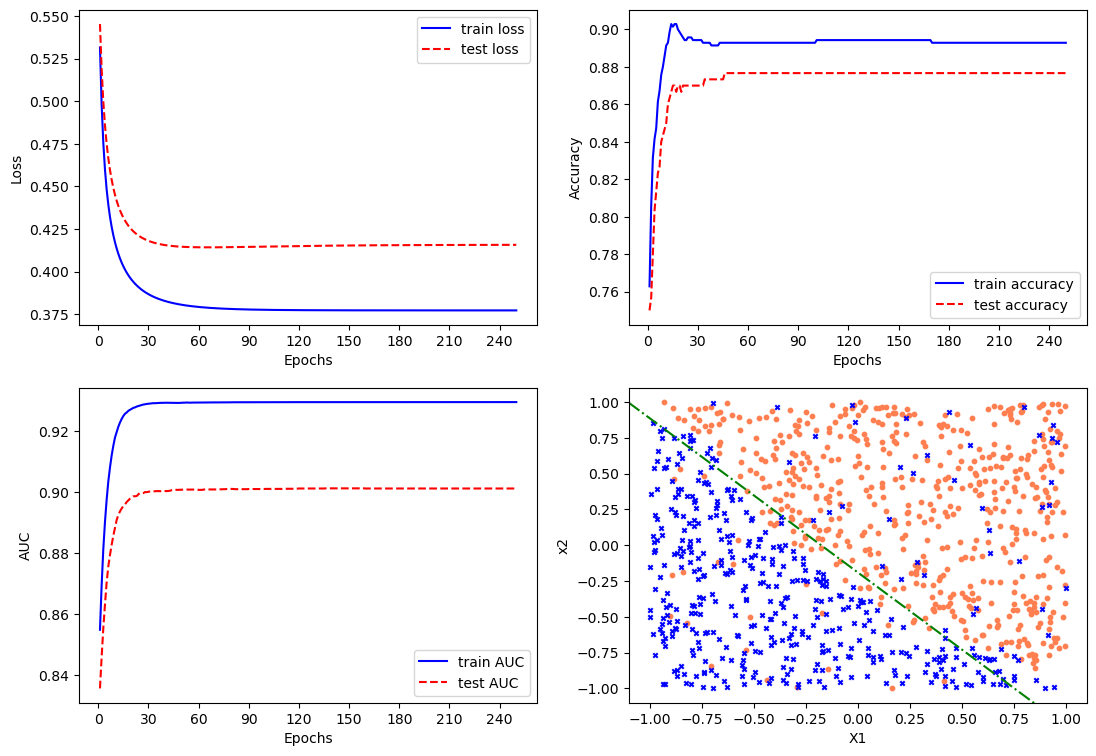

In [45]:
def logistic(z):
    return 1/(1+np.exp(-z))
#num_steps 梯度下降迭代次数 learning_rate 学习率， l2_coef L2 正则系数
def GD(num_steps,learning_rate,l2_coef):
    theta =np.random.normal(size=(X.shape[1],))
    train_losses=[]
    test_losses=[]
    train_acc=[]
    test_acc=[]
    train_auc=[]
    test_auc=[]
    for i in range(num_steps):
        pred = logistic(X @ theta)
        # 计算梯度
        grad=-X.T @ (y_train - pred) + l2_coef * theta
        # 回归系数
        theta-= learning_rate * grad
        # 记录损失函数
        # np.linalg.norm 计算范数 ， 默认l2 范数， 即 n项平方的和再开根号， 即欧几里得范数
        train_loss= - y_train.T @ np.log(pred) - (1-y_train).T @ np.log(1-pred)  +l2_coef * np.linalg.norm(theta) **2 /2
        train_losses.append(train_loss/len(X))
        test_pred=logistic(X_test @ theta)
        test_loss= - y_test.T @ np.log(test_pred) \
                    -(1-y_test).T @ np.log(1-test_pred)
        test_losses.append(test_loss/ len(X_test))
        # 记录各个评价指标，阈值采用0.5
        train_acc.append(acc(y_train,pred >=0.5))
        test_acc.append(acc(y_test,test_pred >= 0.5))
        train_auc.append(auc(y_train,pred))
        test_auc.append(auc(y_test,test_pred))
    return theta, train_losses,test_losses, \
    train_acc,test_acc,train_auc,test_auc
# 定义 梯度下降迭代的次数，学习率，以及l2 正则系数
num_steps=250
learning_rate=0.002
l2_coef=1.0
np.random.seed(0)

# 在x矩阵上拼接1
# ones 函数 两个参数分别控制行，列
X = np.concatenate([x_train,np.ones((x_train.shape[0],1))],axis=1)
X_test = np.concatenate([x_test,np.ones((x_test.shape[0],1))],axis=1)
theta,train_losses,test_losses,train_acc,test_acc,train_auc,test_auc=GD(num_steps,learning_rate,l2_coef)

# 计算测试集上的预测准确率， where 条件后面1，0 是输出 条件 返回真 为1，假为0
y_pred=np.where(logistic(X_test @ theta) >= 0.5 ,1,0)
final_acc=acc(y_test,y_pred)
print('预测准确率',final_acc)

plt.figure(figsize=(13,9))
xticks=np.arange(num_steps)+1
# 绘图
plt.subplot(221)
plt.plot(xticks, train_losses, color='blue', label='train loss')
plt.plot(xticks, test_losses, color='red', ls='--', label='test loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# acc
plt.subplot(222)
plt.plot(xticks,train_acc,c='b',label='train accuracy')
plt.plot(xticks,test_acc,c='r',ls='--',label='test accuracy')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#AUC
plt.subplot(223)
plt.plot(xticks,train_auc,c='b',label='train AUC')
plt.plot(xticks,test_auc,c='r',ls='--',label='test AUC')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
# 模型学习到的分割直线
plt.subplot(224)
plot_x=np.linspace(-1.1,1.1,100)
# 直线方程：theta_0*x_1 +theta_1*x_2 +theta_2 =0
plot_y = -(theta[0] * plot_x + theta[2])/theta[1]
pos_index=np.where(y_total==1)
neg_index=np.where(y_total==0)
plt.scatter(x_total[pos_index,0],x_total[pos_index,1],marker='o',c='coral',s=10)
plt.scatter(x_total[neg_index,0],x_total[neg_index,1],marker='x',c='b',s=10)
plt.plot(plot_x,plot_y,ls='-.',c='g')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.xlabel('X1')
plt.ylabel('x2')
plt.show()

In [49]:
#sklearn  实现

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(x_train,y_train)
print('回归系数：',lr_clf.coef_[0],lr_clf.intercept_)
y_pred=lr_clf.predict(x_test)
print('准确率：', np.mean(y_pred==y_test))

回归系数： [3.14129907 2.91620111] [0.5518978]
准确率： 0.8766666666666667
